In [ ]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1


import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)


import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
sns.set()

import statsmodels.api as sm
from scipy.stats import chisquare

from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error as MSE
from sklearn.metrics import precision_recall_fscore_support as report
from sklearn.preprocessing import StandardScaler

import helpers as hlp
%aimport helpers
import settings
from data.preprocessing import load_file,save_file,filter_by_season,get_scaled_series,display_df
%aimport data.preprocessing
from features import tools
%aimport features.tools

pd.options.display.max_rows = 10

from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

row_headers=["Product"]


%matplotlib inline

In [7]:
p1cc = load_file("p1cc",index="Product")
s = "Autumn"
v = 1
clustering_model = "nb_p2_clusters_%s"%(s)
# clustering_model = "p2_clusters_Autumn_v99"

#Load files
raw_df = load_file("p2_raw").set_index(row_headers)
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)

#Filter and normalize
sclean_df = filter_by_season(clean_df,s)
zclean_df,_ =  get_scaled_series(sclean_df)

#clustering result
cluster_df = load_file(clustering_model,index=row_headers,type_="M",version = v)

#cleaned features
features_df = load_file('clf_features',type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))

numeric = (list(features_df.columns.to_series().groupby(features_df.dtypes).groups[np.dtype('float64')]))
features_list = list(features_df.columns) + ["Cluster"]
df = features_df.join(cluster_df,how="inner")[features_list]

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder

features_df = df[features_list].copy()
data = features_df.drop_duplicates().copy()

In [15]:
import pickle
from sklearn.externals import joblib
X_train = joblib.load(models_path+'Xtrain_demo.pkl')
X_test = joblib.load(models_path+'X_test_demo.pkl')
y_train = joblib.load(models_path+'y_train_demo.pkl')
y_test = joblib.load(models_path+'y_test_demo.pkl')
classifier = joblib.load(models_path+'classifier_demo.pkl')


y_pred_proba=classifier.model.predict_proba(X_test)

In [16]:
argsorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
nguess = argsorted[:,0:4]+1

series_df = raw_df.copy()
predictions = nguess
n_pred = predictions.shape[1]
pred_df = pd.DataFrame(predictions,columns=["PC%d"%g for g in np.arange(n_pred)+1 ],index=X_test.index)

cluster_centroid = cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


for i in np.arange(n_pred)+1:
    pred_df["PR%d"%i] = pred_df["PC%d"%i].apply(lambda x: cluster_centroid[x])
    
product_centroid = X_test.join(cluster_df)[["Cluster","Centroid"]]
full_series = pred_df.join(product_centroid.join(series_df.astype(np.float64), how="inner"),how="inner")

print(full_series.shape)
display(full_series.sort_index().head().iloc[:,:])

(210, 26)


,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
31C002201_2,7,5,9,4,335011700_2,335025200_2,331032200_2,336012400_2,4,336012400_2,...,214.0,158.0,124.0,127.0,84.0,35.0,23.0,29.0,11.0,6.0
31C002500_2,7,6,9,5,335011700_2,331700300_2,331032200_2,335025200_2,9,331032200_2,...,103.0,23.0,43.0,7.0,8.0,37.0,4.0,12.0,5.0,5.0
31C999901_2,7,6,2,8,335011700_2,331700300_2,331051800_2,337015200_2,6,331700300_2,...,38.0,20.0,23.0,7.0,8.0,51.0,26.0,57.0,38.0,84.0
31C999903_2,6,7,9,10,331700300_2,335011700_2,331032200_2,338009400_2,6,331700300_2,...,13.0,7.0,10.0,2.0,3.0,12.0,8.0,20.0,11.0,62.0
31C999904_2,10,4,8,1,338009400_2,336012400_2,337015200_2,331050900_2,10,338009400_2,...,3181.0,5041.0,6729.0,8027.0,3381.0,4582.0,2675.0,2281.0,1501.0,943.0


In [200]:
def getMSE(true,pred):
    return (( (true - pred) ** 2)).mean()
def getMAE(true,pred):
     return (np.abs((true - pred))).mean()

def getMAPE(true,pred):
    return np.abs((true - pred)/true).mean()

def getsMAPE(true,pred):
    return  ( (200*np.abs(true - pred)) / true+pred).mean()


def getMASE(training_series, testing_series, prediction_series,m=1):

    T = training_series.shape[0]
    diff=[]
    for i in range(m, T):
        value = training_series[i] - training_series[i - m]
        diff.append(value)
    d = np.abs(diff).sum()/(T-m)
    errors = np.abs(testing_series - prediction_series )

    return errors.mean()/d

In [ ]:
p_series = full_series.copy()
N = p_series.shape[0]
notin = p_series[ (p_series.Cluster!=p_series.PC1) & (p_series.Cluster!=p_series.PC2) &(p_series.Cluster!=p_series.PC3)  &(p_series.Cluster!=p_series.PC4)].shape[0]

print("%.2f Not in Top 4 guesses"%(notin/N*100))



offset = (n_pred * 2) + 2
guess = 1

s_true = np.zeros((series_df.shape))
s_pred = np.zeros((series_df.shape))
MSE = np.zeros((p_series.shape[0],1))
MAE =  np.zeros((p_series.shape[0],1))
MAPE = np.zeros((p_series.shape[0],1))
sMAPE = np.zeros((p_series.shape[0],1))
i = 0
for index,values in p_series.iterrows():
    centroid = values["PR%d"%guess]
    cluster = values["Centroid"]
    
    #Getting the series raw, centroid of actual cluster, centroid of predicted cluster
    series = (values[offset:]).astype(np.float64)#/values[offset:].std()).astype(np.float64)
    c_series = (series_df.loc[cluster]).astype(np.float64)#/series_df.loc[cluster].std()).astype(np.float64)
    predicted_series = (series_df.loc[centroid]).astype(np.float64)#/series_df.loc[centroid].std()).astype(np.float64)
    
    s_true[i] = series
    s_pred[i] = c_series
    
    n = len(series)
    mse = getMSE(series,predicted_series)
    mae = getMAE(series,predicted_series)
    mape = getMAPE(series+1,predicted_series+1)
    smape = getsMAPE(series,predicted_series)
    
    MSE[i] = mse
    MAE[i] = mae
    MAPE[i] = mape
    sMAPE[i] = smape
    i+=1

In [170]:
sales = p_series.values[:,offset:].astype(np.float64)
p_series["RMSE"] = np.sqrt(MSE)
p_series["MAE"] = MAE
p_series["MAPE"] = MAPE
results = pd.DataFrame(index = p_series.index)

p_series.fillna(0, inplace = True)

results["Mean"] = sales.mean(axis=1)
results["Std"]  = sales.std(axis=1)
results["Range"] = sales.max(axis=1) - sales.min(axis=1)
results["RMSE"] = np.sqrt(MSE)
results["MAE"] = MAE
results["MAPE"] = MAPE

results.nsmallest(210,"MAE").head(25)

results.MAPE.describe()
np.median(results.MAPE)

3.2164385331561829

# Plots 

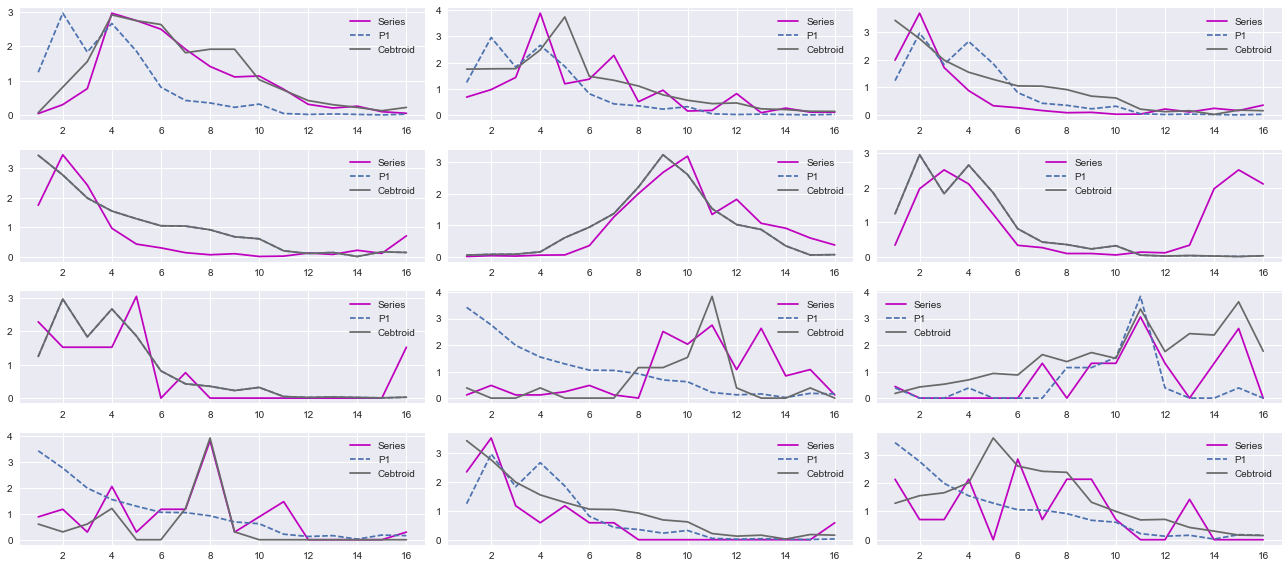

In [171]:
plt.figure(figsize=(18,2 * 4))
i=1;

disp = p_series.iloc[:12,:-3]#.loc[bad.index[:12]]

for index,values in disp.iterrows():
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    series = values[offset:]/values[offset:].std()
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    predicted_series = series_df.loc[guess1]/series_df.loc[guess1].std()
    
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(predicted_series,label="P1",ls='--')
    plt.plot(c_series,label="Cebtroid",c='dimgrey')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
    #plt.plot(p4,label="P4",ls='--')
    
    #show the centroid as well
    
    
    plt.legend(loc=0)
    
    i+=1
    

plt.tight_layout()
plt.show()

# Predict Quantities

In [172]:
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score
features_df = load_file("clf_features",type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))

from sklearn.externals import joblib

features_df.head()
encoded_df = tools.encode(features_df,non_categorical = ["Tprice"]+["s1","s2","s3","s4","s5"])
encoded_df.head()

,Ptype_Boat Socks,Ptype_Core Material,Ptype_Core Wire,Ptype_Core Wrap,Ptype_Core Yarn,Ptype_Disable,Ptype_Discontinued,Ptype_Invisible Socks,Ptype_Medium Thick,Ptype_Medium-Thickness,...,Age Group_29-38,Age Group_39-48,Age Group_4-6,Age Group_7-9,Tprice,s1,s2,s3,s4,s5
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.134078,0.000000,0.002113,0.003519,0.002837,0.001767
30E000400_2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.106145,0.055102,0.156338,0.183673,0.195035,0.164311
30E823101_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.106145,0.002041,0.010563,0.012667,0.021277,0.017668
30E823102_2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.106145,0.007143,0.018310,0.022519,0.023404,0.024146
30E823103_2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.106145,0.002041,0.010563,0.023223,0.028369,0.021201


## Calculates

In [214]:
predictor = joblib.load(models_path+'regressor_std_log.pkl')

disp = p_series.iloc[:,:-3]

FMSE = np.zeros((disp.shape[0],1))
FMAE =  np.zeros((disp.shape[0],1))
FMAPE = np.zeros((disp.shape[0],1))
FsMAPE = np.zeros((disp.shape[0],1))
FMASE =  np.zeros((disp.shape[0],1))
i=0
for index,values in disp.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = np.exp(prediction)
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    
    mse = getMSE(series,p1)
    mae = getMAE(series,p1)
    mape = getMAPE(series+1,p1+1)
    mase = getMASE(series,series,p1)

    FMSE[i] = mse
    FMAE[i] = mae
    FMAPE[i] = mape
    FMASE[i] = mase
    
    try:
        smape = getsMAPE(series,p1)
        FsMAPE[i]=smape
    except:
        FsMAPE[i]=0
    i+=1




,Mean,Std,Range,RMSE,MAE,MAPE,MASE
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,343.826997,305.594226,1126.145775,267.354828,202.927839,1.084276,1.612711
std,792.285712,609.203954,2227.262695,719.819579,529.862976,0.907024,1.386577
min,0.729495,0.870841,3.000000,0.757752,0.558915,0.009635,0.029531
25%,23.792349,44.500844,178.372422,4.968293,3.672515,0.537618,0.833771
50%,125.780674,146.729751,610.890853,36.173632,25.900648,0.805387,1.231989
75%,350.773269,388.354350,1451.517491,216.497762,172.946679,1.260518,1.753011
max,8581.383437,6196.975949,24964.037235,6195.373850,5130.827377,6.265484,9.106976


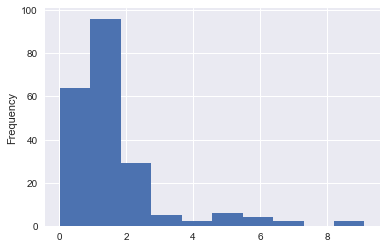

In [222]:
sales = p_series.values[:,offset:].astype(np.float64)
disp["RMSE"] = np.sqrt(FMSE)
disp["MAE"] = FMAE
disp["MAPE"] = FMAPE
disp["MASE"] = FMASE

fresults = pd.DataFrame(index = p_series.index)
p_series.fillna(0, inplace = True)

fresults["Mean"] = sales.mean(axis=1)
fresults["Std"]  = sales.std(axis=1)
fresults["Range"] = sales.max(axis=1) - sales.min(axis=1)
fresults["RMSE"] = np.sqrt(FMSE)
fresults["MAE"] = FMAE
fresults["MAPE"] = FMAPE
fresults["MASE"] = FMASE


fresults.nsmallest(210,"MAE").head()

display(fresults.describe())
# fresults[fresults.MAE<500].MAE.plot(kind="box")

# nosmall = fresults.MAE<fresults.Std
# fresults[nosmall].MAPE.plot(kind="box")

# fresults.MASE.plot(kind="box")
fresults.MASE.plot(kind="hist")

### Display Plots

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,11,12,13,14,15,16,RMSE,MAE,MAPE,MASE
Product,,,,,,,,,,,,,,,,,,,,,
335030700_2,8,9,7,1,337015200_2,331032200_2,335011700_2,331050900_2,7,335011700_2,...,110.0,112.0,72.0,37.0,15.0,14.0,733.762018,595.336793,2.837933,5.016883
328028100_2,9,7,12,2,331032200_2,335011700_2,331032500_2,331051800_2,7,335011700_2,...,38.0,35.0,21.0,13.0,14.0,13.0,252.458893,190.857687,1.970330,5.243343
332018300_2,7,9,6,5,335011700_2,331032200_2,331700300_2,335025200_2,6,331700300_2,...,4.0,4.0,1.0,1.0,1.0,0.0,30.250035,17.336296,1.129072,5.307029
331050900_2,1,2,8,4,331050900_2,331051800_2,337015200_2,336012400_2,1,331050900_2,...,632.0,665.0,863.0,462.0,652.0,367.0,1162.675105,1066.261373,1.928665,5.343776
335014300_2,9,7,5,6,331032200_2,335011700_2,335025200_2,331700300_2,9,331032200_2,...,9.0,3.0,3.0,3.0,1.0,0.0,33.495850,24.517572,1.854317,5.489009


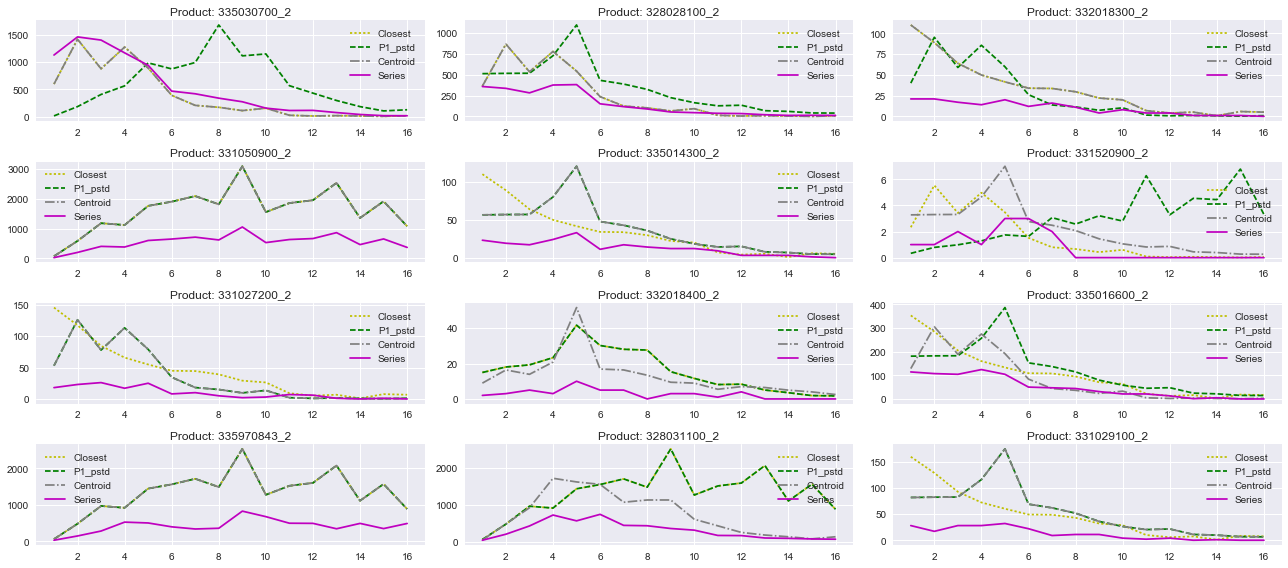

In [223]:
from sklearn.neighbors import NearestNeighbors

# slices = 5 * 12
# display_result = disp.nsmallest(disp.shape[0],"MAE").iloc[slices:slices+12,:-3]

slices = -1 * 12
display_result = disp.nsmallest(disp.shape[0],"MASE").iloc[slices:,:-4]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))

n_points = 3
i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = np.exp(prediction)
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    
    plt.subplot(4,3,i)
    
    first_std = series[:n_points].std()
    if (first_std)==0: first_std = 1
    first_points = series[:n_points]/first_std
    
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.title("Product: %s" % (index))
        
    #Adjusted
    knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    knn.fit(p_array.iloc[:,:n_points])  
    closest = knn.kneighbors([first_points], 1, return_distance=False)[0][0]
    
#     cstd = (series[:n_points]/p_array.iloc[closest,:n_points]).median()
    
    #multiply by the caluclated std
#     p1c = p1 * cstd 
    p1p = p1 * pstd[0] 
    c_series *=  pstd[0]
    
    
#     plt.plot(p1c,label="P1_cstd",ls='--',c='b')
    plt.plot(p_array.iloc[closest]*pstd,label="Closest",c='y',ls=':')
    plt.plot(p1p,label="P1_pstd",ls='--',c='g')
    
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    plt.plot(series,label="Series",c='m')

    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()